# Transcribe Handwritten images

## Initialization

In [1]:
# Install required libraries
!pip install -qU torch_snippets torchsummary editdistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.8/401.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 4.3 MB/s eta 

In [2]:
# Import libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch_snippets import *
from torch_snippets import Reshape, Permute
from torchsummary import summary

import cv2
import editdistance

from sklearn.model_selection import train_test_split

print(f"PyTorch Version: {torch.__version__}")
!nvidia-smi # check if GPU is available
%matplotlib inline

PyTorch Version: 2.2.1+cu121
Tue May  7 23:35:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+--------------------------------------

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda


In [4]:
# Download the dataset and unzip it
!wget https://www.dropbox.com/s/l2ul3upj7dkv4ou/synthetic-data.zip
!unzip -qq synthetic-data.zip

# Get the list of images
images = Glob('/content/synthetic-data')

# Create a function to get the label from the filename
fname2label = lambda fname: stem(fname).split('@')[0]

--2024-05-07 23:35:19--  https://www.dropbox.com/s/l2ul3upj7dkv4ou/synthetic-data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/l2ul3upj7dkv4ou/synthetic-data.zip [following]
--2024-05-07 23:35:19--  https://www.dropbox.com/s/raw/l2ul3upj7dkv4ou/synthetic-data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfa7d125fc497412e4685f4378f.dl.dropboxusercontent.com/cd/0/inline/CScVmFa8fdREUHZx2QoxLWOVZo8NNBo-mXCMvhKekr8-g9gvXp_YWTlJ0UwiyB5CHY1vDF8uITULG6O1Nwf63xEKd6n6eQGnEZJl3I08b4vSYSzcpn5hvvXZL2msHbZFwonUbP-XQ-oLeWdFpzg76u_F/file# [following]
--2024-05-07 23:35:20--  https://ucfa7d125fc497412e4685f4378f.dl.dropboxusercontent.com/cd/0/inline/CScVmFa8fdREUHZx2QoxLWOVZo8NNBo-mXCMvhKekr8-g9gvXp_YWTlJ0UwiyB5CHY1vDF8uITULG6O1Nwf6

In [4]:
# Define the vocabulary of characters
vocab = 'QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm'

# Set the values for Batch Size, Time Steps, Vocabulary Size, and Image Dimensions
B, T, V = 64, 32, len(vocab)
H, W = 32, 128

In [6]:
# Create a class to load the OCR dataset
class OCRDataset(Dataset):
    def __init__(self, items, vocab=vocab, timesteps=T):
        super().__init__()
        self.items = items
        self.charList = {ix+1: ch for ix, ch in enumerate(vocab)}
        self.charList[0] = '`'
        self.invCharList = {v: k for k, v in self.charList.items()}
        self.timesteps = timesteps

    def __len__(self):
        return len(self.items)

    def sample(self):
        return self[randint(len(self))]

    def __getitem__(self, idx):
        item = self.items[idx]
        image = read(item, 0)
        label = fname2label(item)
        return image, label

    def collate_fn(self, batch):
        images, labels, label_lengths, label_vectors, input_lengths = [], [], [], [], []
        for image, label in batch:
            images.append(torch.Tensor(self.preprocess(image))[None, None])
            label_lengths.append(len(label))
            labels.append(label)
            label_vectors.append(self.str2vec(label))
            input_lengths.append(self.timesteps)
        images = torch.cat(images).float().to(device)
        label_lengths = torch.Tensor(label_lengths).long().to(device)
        label_vectors = torch.Tensor(label_vectors).long().to(device)
        input_lengths = torch.Tensor(input_lengths).long().to(device)
        return images, label_vectors, label_lengths, input_lengths, labels

    def str2vec(self, string, pad=True):
        string = ''.join([s for s in string if s in self.invCharList])
        val = list(map(lambda x: self.invCharList[x], string))
        if pad:
            while len(val) < self.timesteps:
                val.append(0)
        return val

    def preprocess(self, image, shape=(H, W)):
        target = np.ones(shape)*255
        try:
            H, W = shape
            h, w = image.shape
            fx = H/h
            fy = W/w
            f = min(fx, fy)
            _h = int(h*f)
            _w = int(w*f)
            _image = cv2.resize(image, (_w, _h))
            target[:_h, :_w] = _image
        except Exception:
            ...
        return (255-target)/255

    def decoder_chars(self, pred):
        decoded = ""
        last = ""
        pred = pred.cpu().detach().numpy()
        for i in range(len(pred)):
            k = np.argmax(pred[i])
            if k > 0 and self.charList[k] != last:
                last = self.charList[k]
                decoded = decoded + last
            elif k > 0 and self.charList[k] == last:
                continue
            else:
                last = ""
        return decoded.replace(" "," ")

    def wer(self, preds, labels):
        c = 0
        for p, l in zip(preds, labels):
            c += p.lower().strip() != l.lower().strip()
        return round(c/len(preds), 4)

    def cer(self, preds, labels):
        c, d = [], []
        for p, l in zip(preds, labels):
            c.append(editdistance.eval(p, l) / len(l))
        return round(np.mean(c), 4)

    def evaluate(self, model, images, labels):
        model.eval()
        preds = model(images).permute(1, 0, 2) # B, T, V+1
        preds = [self.decoder_chars(pred) for pred in preds]
        return {'char-error-rate': self.cer(preds, labels),
                'word-error-rate': self.wer(preds, labels),
                'char-accuracy' : 1 - self.cer(preds, labels),
                'word-accuracy' : 1 - self.wer(preds, labels)}

In [7]:
# Create train and validation datasets
train_items, val_items = train_test_split(images, test_size=0.2, random_state=4)
train_ds = OCRDataset(train_items)
val_ds = OCRDataset(val_items)

# Create a function to retrieve the dataloaders
def load_data(batch_size = B):
    train_dl = DataLoader(train_ds, batch_size=batch_size, collate_fn=train_ds.collate_fn, drop_last=True, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn, drop_last=True)
    return train_dl, val_dl

In [2]:
# Create a class to define a Basic Block (CNN) for the model
class BasicBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, ks=3, st=1, padding=1, pool=2, drop=0.2):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(n_inputs, n_outputs, kernel_size=ks, stride=st, padding=padding),
            nn.BatchNorm2d(n_outputs, momentum=0.3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool),
            nn.Dropout2d(drop)
        )

    def forward(self, x):
        return self.block(x)

# Create a class for the OCR model
class OCR(nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.model = nn.Sequential(
            BasicBlock(1, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 256, pool=(4, 2)),
            Reshape(-1, 256, 32),
            Permute(2, 0, 1) # T, B, D
        )
        self.rnn = nn.Sequential(
            nn.LSTM(256, 256, num_layers=2, dropout=0.2, bidirectional=True),
        )
        self.classification = nn.Sequential(
            nn.Linear(512, vocab+1),
            nn.LogSoftmax(-1),
        )
    def forward(self, x):
        x = self.model(x)
        x, _ = self.rnn(x) # Discard LSTM states
        y = self.classification(x)
        return y

In [7]:
# Create a mock-up model and print summary
model = OCR(len(vocab)).to(device)
summary(model, (1, H, W))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2, 256]              --
|    └─BasicBlock: 2-1                   [-1, 128, 16, 64]         --
|    |    └─Sequential: 3-1              [-1, 128, 16, 64]         1,536
|    └─BasicBlock: 2-2                   [-1, 128, 8, 32]          --
|    |    └─Sequential: 3-2              [-1, 128, 8, 32]          147,840
|    └─BasicBlock: 2-3                   [-1, 256, 2, 16]          --
|    |    └─Sequential: 3-3              [-1, 256, 2, 16]          295,680
|    └─Reshape: 2-4                      [-1, 256, 32]             --
|    └─Permute: 2-5                      [-1, 2, 256]              --
├─Sequential: 1-2                        [-1, 2, 512]              --
|    └─LSTM: 2-6                         [-1, 2, 512]              2,629,632
├─Sequential: 1-3                        [-1, 2, 53]               --
|    └─Linear: 2-7                       [-1, 2, 53]             

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2, 256]              --
|    └─BasicBlock: 2-1                   [-1, 128, 16, 64]         --
|    |    └─Sequential: 3-1              [-1, 128, 16, 64]         1,536
|    └─BasicBlock: 2-2                   [-1, 128, 8, 32]          --
|    |    └─Sequential: 3-2              [-1, 128, 8, 32]          147,840
|    └─BasicBlock: 2-3                   [-1, 256, 2, 16]          --
|    |    └─Sequential: 3-3              [-1, 256, 2, 16]          295,680
|    └─Reshape: 2-4                      [-1, 256, 32]             --
|    └─Permute: 2-5                      [-1, 2, 256]              --
├─Sequential: 1-2                        [-1, 2, 512]              --
|    └─LSTM: 2-6                         [-1, 2, 512]              2,629,632
├─Sequential: 1-3                        [-1, 2, 53]               --
|    └─Linear: 2-7                       [-1, 2, 53]             

In [10]:
# Create a function to calculate the CTC Loss
def ctc(log_probs, target, input_lengths, target_lengths, blank=0):
    loss = nn.CTCLoss(blank=blank, zero_infinity=True)
    return loss(log_probs, target, input_lengths, target_lengths)

In [11]:
# Create a function to train the model on a batch of data
def train_batch(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    images, targets, label_lens, input_lens, labels = data
    preds = model(images)
    loss = criterion(preds, targets, input_lens, label_lens)
    loss.backward()
    optimizer.step()
    return loss, train_ds.evaluate(model, images.to(device), labels)

# Create a function to validate the model on a batch of data
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    images, targets, label_lens, input_lens, labels = data
    preds = model(images)
    loss = criterion(preds, targets, input_lens, label_lens)
    return loss, val_ds.evaluate(model, images.to(device), labels)

In [12]:
# Train the model
model = OCR(len(vocab)).to(device)
criterion = ctc
optimizer = optim.AdamW(model.parameters(), lr=3e-3)
train_dl, val_dl = load_data()
n_epochs = 50

log = Report(n_epochs)
for epoch in range(n_epochs):
    n = len(train_dl)
    for i, data in enumerate(train_dl):
        loss, results = train_batch(model, data, criterion, optimizer)
        ca, wa = results['char-accuracy'], results['word-accuracy']
        log.record(epoch+(i+1)/n, train_loss=loss, train_char_acc=ca, train_word_acc=wa, end='\r')

    n = len(val_dl)
    for i, data in enumerate(val_dl):
        loss, results = validate_batch(model, data, criterion)
        ca, wa = results['char-accuracy'], results['word-accuracy']
        log.record(epoch+(i+1)/n, val_loss=loss, val_char_acc=ca, val_word_acc=wa, end='\r')

    log.report_avgs(epoch+1)

    print()
    for _ in range(5):
        image, label = val_ds.sample()
        _img = torch.Tensor(val_ds.preprocess(image)[None,None]).to(device)
        pred = model(_img)[:, 0, :]
        pred = train_ds.decoder_chars(pred)
        print(f'Pred: `{pred}` :: Truth: `{label}`')

EPOCH: 1.000  train_char_acc: 0.012  val_loss: 2.978  train_word_acc: 0.000  val_char_acc: 0.064  train_loss: 3.304  val_word_acc: 0.000  (39.54s - 1937.65s remaining)

Pred: `t` :: Truth: `these`
Pred: `s` :: Truth: `fact`
Pred: `s` :: Truth: `role`
Pred: `t` :: Truth: `hand`
Pred: `s` :: Truth: `reason`
EPOCH: 2.000  train_char_acc: 0.215  val_loss: 2.297  train_word_acc: 0.002  val_char_acc: 0.313  train_loss: 2.751  val_word_acc: 0.007  (72.06s - 1729.50s remaining)

Pred: `mee` :: Truth: `piece`
Pred: `strete` :: Truth: `strategy`
Pred: `preent` :: Truth: `present`
Pred: `prdetlt` :: Truth: `probably`
Pred: `alie` :: Truth: `allow`
EPOCH: 3.000  train_char_acc: 0.467  val_loss: 1.478  train_word_acc: 0.044  val_char_acc: 0.564  train_loss: 1.974  val_word_acc: 0.095  (105.96s - 1660.11s remaining)

Pred: `pict` :: Truth: `pick`
Pred: `culturel` :: Truth: `cultural`
Pred: `cprorese` :: Truth: `Congress`
Pred: `solicr` :: Truth: `soldier`
Pred: `current` :: Truth: `current`
EPOCH: 4

100%|██████████| 151/151 [00:01<00:00, 150.40it/s]


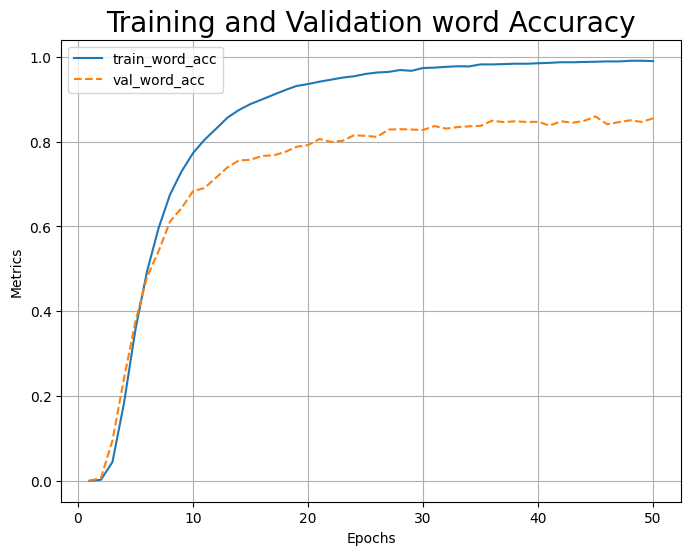

In [13]:
# Plot the training and validation losses
log.plot_epochs(['train_word_acc','val_word_acc'], title='Training and Validation word Accuracy')